# Cancer Dataset Exploration

Insights drawn from the sample dataset (`2022Data_part1.csv`) focusing on feature patterns against the `Vital status recode` label.


In [50]:
# 데이터 분석 및 시각화에 필요한 라이브러리들을 가져옵니다.
# pathlib: 파일 경로를 쉽게 다루기 위한 라이브러리
from pathlib import Path
# display: Jupyter Notebook에서 데이터프레임 등을 예쁘게 출력하기 위해 사용
from IPython.display import display

# 기본 호출
import matplotlib.pyplot as plt
import matplotlib.ticker as mstick
import numpy as np
import pandas as pd
import seaborn as sns
import platform

from matplotlib import rcParams

# modules
import modules.DataSelect as DataSelect
import modules.DataAnalysis as DataAnalysis
import modules.ModelAnalysis as ModelAnalysis
import modules.DataModify as DataModify
from modules.DataModify import DataPreprocessing

import modules.Models as Models


# csv 파일 안전하게 읽기 (PC 메모리가 너무 작음)
from modules.smart_csv import process_csv_stream, csv_to_parquet_stream

# seaborn의 기본 테마를 설정합니다. 'whitegrid' 스타일과 'crest' 색상 팔레트를 사용합니다.
sns.set_theme(style="whitegrid", palette="crest")


In [51]:
# 대용량 CSV를 메모리 부담 없이 불러오기 위한 헬퍼를 정의합니다.
import gc
from itertools import chain

# 분석에 필요한 칼럼 중심으로 로딩하여 초기 메모리 사용량을 줄입니다.
RISK_DATA_USECOLS = [
    'Patient ID',
    'Age recode with <1 year olds and 90+',
    'Sex',
    'Year of diagnosis',
    'Year of follow-up recode',
    'Race recode (W, B, AI, API)',
    'Site recode ICD-O-3/WHO 2008',
    'Primary Site',
    'Primary Site - labeled',
    'Derived Summary Grade 2018 (2018+)',
    'Laterality',
    'EOD Schema ID Recode (2010+)',
    'Combined Summary Stage with Expanded Regional Codes (2004+)',
    'RX Summ--Surg Prim Site (1998+)',
    'RX Summ--Scope Reg LN Sur (2003+)',
    'RX Summ--Surg Oth Reg/Dis (2003+)',
    'COD to site recode',
    'Sequence number',
    'Median household income inflation adj to 2023',
    'Number of Cores Positive Recode (2010+)',
    'Number of Cores Examined Recode (2010+)',
    'EOD Primary Tumor Recode (2018+)',
    'PRCDA 2020',
    'Survival months flag',
    'Survival months',
    'Vital status recode (study cutoff used)',
]


def load_risk_dataset(csv_paths, usecols='auto', chunksize=150_000):
    """Stream multiple CSV files with dtype downcasting and categorical compression."""
    resolved_usecols = RISK_DATA_USECOLS if usecols == 'auto' else usecols

    chunk_streams = (
        process_csv_stream(
            csv_path=str(path),
            usecols=resolved_usecols,
            chunksize=chunksize,
        )
        for path in csv_paths
    )

    frames = list(chain.from_iterable(chunk_streams))
    if not frames:
        columns = resolved_usecols if resolved_usecols not in (None, 'auto') else []
        return pd.DataFrame(columns=columns)

    combined = pd.concat(frames, ignore_index=True)
    del frames
    gc.collect()

    if 'Survival months' in combined.columns:
        combined['Survival months'] = pd.to_numeric(combined['Survival months'], errors='coerce')

    return combined


In [52]:
# 범주형 피처 인코딩/디코딩 유틸리티를 정의합니다.
DECODE_MAPS = {}

# categorical한 데이터 encoding
def category_encoding(df, categories, encoding='label'):
    # encoding : 'label' - 라벨 인코딩, 'onehot' - One-hot 인코딩
    # categories = {'encoding_type':..., '컬럼명':{'요소':'라벨', '요소':'라벨', ...}, ...}
    # categorical한 데이터 = 데이터가 가지는 서로 다른 값이 15개 미만

    categorical_col = DataSelect.return_cols(df, 'categorical', boundary=100)
    df_encoded = df.copy()

    if encoding == 'label':
        categories['encoding_type'] = 'label'

        for col in categorical_col:
            unique_vals = df_encoded[col].unique()
            label = {val: i for i, val in enumerate(unique_vals)}
            df_encoded[col] = df_encoded[col].map(label)
            categories[col] = label

    elif encoding == 'onehot':
        categories['encoding_type'] = 'onehot'

        for col in categorical_col:
            dummies = pd.get_dummies(df_encoded[col], prefix=col)
            df_encoded = pd.concat([df_encoded.drop(columns=[col]), dummies], axis=1)
            categories[col] = dummies.columns.tolist()

    else:
        raise ValueError(f"알 수 없는 encoding_type: {encoding}")

    return df_encoded

# encoding된 데이터 decoding
def category_decoding(df=None, categories=None):
    df_decoded = df.copy()

    if categories is None:
        raise ValueError('categories 정보가 필요합니다.')

    encoding_type = categories.get('encoding_type', None)

    if encoding_type == 'label':
        for col, mapping in categories.items():
            if col == 'encoding_type':
                continue
            reverse_map = {v: k for k, v in mapping.items()}
            df_decoded[col] = df_decoded[col].map(reverse_map)

    elif encoding_type == 'onehot':
        for col, dummy_cols in categories.items():
            if col == 'encoding_type':
                continue

            def decode_row(row):
                for dummy_col in dummy_cols:
                    if row[dummy_col] == 1:
                        return dummy_col.replace(f"{col}_", '')
                return None

            df_decoded[col] = df_decoded.apply(decode_row, axis=1)
            df_decoded = df_decoded.drop(columns=dummy_cols)

    else:
        raise ValueError(f"알 수 없는 encoding_type: {encoding_type}")

    return df_decoded


def build_decode_maps(categories):
    return {
        col: {code: original for original, code in mapping.items()}
        for col, mapping in categories.items()
        if col != 'encoding_type'
    }

def decode_series(frame, column, decode_maps=None):
    maps = decode_maps if decode_maps is not None else DECODE_MAPS
    mapping = maps.get(column)
    if mapping is None:
        return frame[column]
    return frame[column].map(mapping)

def decode_value(column, value, decode_maps=None):
    maps = decode_maps if decode_maps is not None else DECODE_MAPS
    mapping = maps.get(column)
    if mapping is None:
        return value
    return mapping.get(value, value)


In [53]:
import warnings

warnings.filterwarnings('ignore')

In [54]:
# 시각화에서 한글이 깨지지 않도록 나눔고딕 폰트를 설정합니다.
# 시스템에 폰트가 설치되어 있지 않으면 오류가 발생할 수 있어 try-except 구문으로 감쌌습니다.
try:
    plt.rc('font', family='NanumGothic')
except Exception:
    pass
# 마이너스 부호가 깨지는 것을 방지하는 설정입니다.
plt.rc('axes', unicode_minus=False)


### Feature correlation
Heatmap of numeric features after excluding `Patient ID` and encoding `Vital status recode` to inspect its relationship with other predictors.


## DeepSurv risk segmentation (3-month intervals)

`../data/2022Data_short.csv`를 기반으로 DeepSurv 모델 설계를 위한 범주별 위험도 패턴을 살펴봅니다.


In [55]:
# 데이터셋 병합
DATA_PATHS = [
    Path('../data/2022Data_part1.csv'),
    Path('../data/2022Data_part2.csv'),
]
DATA_PATH3 = Path('../data/cancer_self.csv')

# 메모리를 과도하게 사용하지 않도록 청크 단위로 데이터를 결합합니다.
risk_df = load_risk_dataset(DATA_PATHS)
suicide_df = pd.read_csv(DATA_PATH3)

memory_mb = risk_df.memory_usage(deep=True).sum() / 1024 ** 2
print(f"Loaded risk dataset: {risk_df.shape[0]:,} rows, {risk_df.shape[1]} columns (~{memory_mb:.1f} MB)")


Loaded risk dataset: 528,403 rows, 26 columns (~193.1 MB)


In [56]:
# CSV 첫 번째 열이 인덱스일 경우 제거합니다.
if '' in risk_df.columns:
    risk_df = risk_df.drop(columns=[''])

# 기존 노트북과 컬럼 이름을 맞춰 분석을 단순화합니다.
risk_df = risk_df.rename(columns={'Vital status recode (study cutoff used)': 'Vital status recode'})
risk_df['Survival months'] = pd.to_numeric(risk_df['Survival months'], errors='coerce')

category_labels = {
    1: '1 - Primary cancer death',
    2: '2 - Cancer-related complication',
    3: '3 - Non-cancer death',
}
category_order = [1, 2, 3]

def infer_category(row):
    status = row.get('Vital status recode')
    cod = row.get('COD to site recode')
    site = row.get('Site recode ICD-O-3/WHO 2008')

    if pd.isna(status):
        return pd.NA
    if status == 'Alive':
        return pd.NA
    if status == 'Dead':
        if cod == 'Other Cause of Death':
            return 3
        if cod == site:
            return 1
        if pd.isna(cod):
            return 2
        return 2
    return pd.NA

risk_df['category'] = risk_df.apply(infer_category, axis=1).astype('Int64')
risk_df['category_label'] = risk_df['category'].map(category_labels)
risk_df['category_label'] = risk_df['category_label'].fillna('Unclassified (Alive or censored)')
risk_df['event'] = risk_df['category'].isin(category_order)

display(risk_df.head())



,Patient ID,Age recode with <1 year olds and 90+,Sex,Year of diagnosis,Year of follow-up recode,"Race recode (W, B, AI, API)",Site recode ICD-O-3/WHO 2008,Primary Site,Primary Site - labeled,Derived Summary Grade 2018 (2018+),...,Number of Cores Positive Recode (2010+),Number of Cores Examined Recode (2010+),EOD Primary Tumor Recode (2018+),PRCDA 2020,Survival months flag,Survival months,Vital status recode,category,category_label,event
0,671,65-69 years,Male,2018,2022,White,Lung and Bronchus,341,"C34.1-Upper lobe, lung",3,...,Blank(s),Blank(s),450,Not PRCDA,Complete dates are available and there are mor...,59.0,Alive,<NA>,Unclassified (Alive or censored),False
1,812,65-69 years,Female,2022,2022,White,Stomach,163,C16.3-Gastric antrum,L,...,Blank(s),Blank(s),100,Not PRCDA,Complete dates are available and there are mor...,7.0,Alive,<NA>,Unclassified (Alive or censored),False
2,878,60-64 years,Male,2004,2022,White,Appendix,181,C18.1-Appendix,Blank(s),...,Blank(s),Blank(s),Blank(s),Not PRCDA,Complete dates are available and there are mor...,218.0,Alive,<NA>,Unclassified (Alive or censored),False
3,1018,70-74 years,Female,2011,2022,White,Ascending Colon,182,C18.2-Ascending colon,Blank(s),...,Blank(s),Blank(s),Blank(s),Not PRCDA,Complete dates are available and there are mor...,134.0,Alive,<NA>,Unclassified (Alive or censored),False
4,1269,40-44 years,Female,2007,2022,White,Sigmoid Colon,187,C18.7-Sigmoid colon,Blank(s),...,Blank(s),Blank(s),Blank(s),Not PRCDA,Complete dates are available and there are mor...,187.0,Alive,<NA>,Unclassified (Alive or censored),False


In [57]:
# 범주형 피처를 라벨 인코딩하여 메모리 사용량을 줄입니다.
ENCODING_CATEGORIES = {}
encoded_df = category_encoding(risk_df, categories=ENCODING_CATEGORIES, encoding='label')
DECODE_MAPS = build_decode_maps(ENCODING_CATEGORIES)

category_map = ENCODING_CATEGORIES.get('category', {})
if category_map:
    category_order = [category_map[val] for val in category_order if val in category_map]
    category_labels = {category_map[k]: v for k, v in category_labels.items() if k in category_map}

encoded_memory_mb = encoded_df.memory_usage(deep=True).sum() / 1024 ** 2
print(f"Encoded dataset ready: {encoded_df.shape[0]:,} rows, {encoded_df.shape[1]} columns (~{encoded_memory_mb:.1f} MB)")

del risk_df


Encoded dataset ready: 528,403 rows, 29 columns (~65.5 MB)


In [58]:
# 범주별 생존 기간(월) 분포의 기술 통계량을 계산합니다.
timing_base = (
    encoded_df[['Survival months', 'category', 'category_label']]
      .copy()
)

timing_base['category_label'] = decode_series(timing_base, 'category_label')

timing_by_category = (
    timing_base
      .assign(**{'Survival months': lambda d: pd.to_numeric(d['Survival months'], errors='coerce')})
      .dropna(subset=['Survival months', 'category'])
      .loc[lambda d: d['category'].isin(category_order)]
      .assign(**{'Survival months': lambda d: d['Survival months'].clip(lower=0)})
      .copy()
)

survival_summary = (
    timing_by_category
      .groupby(['category', 'category_label'])['Survival months']
      .describe()
      .round(2)
      .reset_index()
      .sort_values('category')
      .set_index('category_label')
      .drop(columns=['category'])
)

display(survival_summary)


,count,mean,std,min,25%,50%,75%,max
category_label,,,,,,,,
1 - Primary cancer death,34317.0,21.33,33.66,0.0,2.0,8.0,26.0,269.0
2 - Cancer-related complication,35777.0,58.24,67.26,0.0,6.0,30.0,90.0,275.0
3 - Non-cancer death,6989.0,79.42,76.37,0.0,11.0,55.0,134.0,273.0


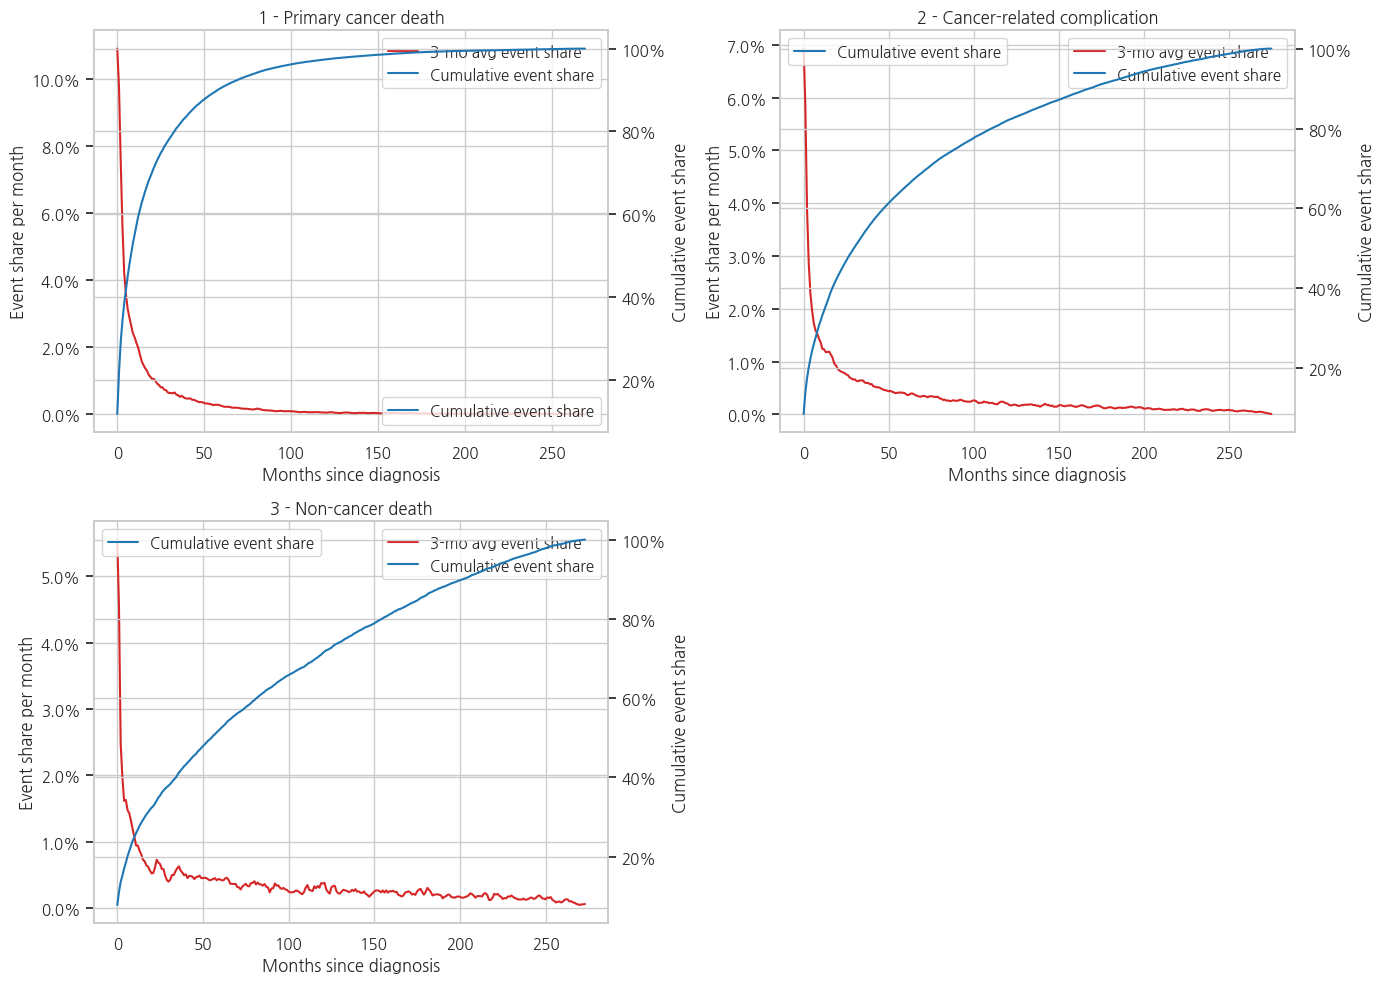

,category,category_label,Month since diagnosis,Events,Event share,Event share (3-mo avg),Cumulative event share
0,1.0,1 - Primary cancer death,0,4044,0.117842,0.109013,0.117842
1,1.0,1 - Primary cancer death,1,3438,0.100184,0.097522,0.218026
2,1.0,1 - Primary cancer death,2,2558,0.074540,0.075230,0.292566
3,1.0,1 - Primary cancer death,3,1749,0.050966,0.055687,0.343532
4,1.0,1 - Primary cancer death,4,1426,0.041554,0.041971,0.385086


In [59]:
# 진단 후 경과 월에 따른 월별 및 누적 사건 비중 변화를 범주별로 시각화합니다.
def build_monthly_event_trend(df):
    # 각 범주별 데이터프레임을 받아 월별 사건 수와 비율을 계산하는 함수입니다.
    if df.empty:
        # 분석할 데이터가 없으면 비어 있는 데이터프레임을 반환해 이후 계산에서 에러가 나지 않도록 합니다.
        return pd.DataFrame({
            'Month since diagnosis': [],
            'Events': [],
            'Event share': [],
            'Event share (3-mo avg)': [],
            'Cumulative event share': [],
        })

    # 생존 개월 수를 가장 가까운 정수로 반올림한 뒤, 월별 사건 수를 세어 새로운 표를 만듭니다.
    monthly = (
        df.assign(**{'Month since diagnosis': lambda d: d['Survival months'].round().astype(int)})
          .groupby('Month since diagnosis')
          .size()
          .reindex(range(0, int(df['Survival months'].max()) + 1), fill_value=0)
          .rename('Events')
          .reset_index()
    )

    # 총 사건 수를 구해 각 월의 사건 비중을 계산합니다.
    total_events = monthly['Events'].sum()
    if total_events == 0:
        # 사건이 하나도 없으면 비율은 모두 0으로 둡니다.
        monthly['Event share'] = 0.0
    else:
        monthly['Event share'] = monthly['Events'] / total_events

    # 최근 3개월간 평균 사건 비중을 구해 들쭉날쭉한 그래프를 부드럽게 만듭니다.
    monthly['Event share (3-mo avg)'] = (
        monthly['Event share']
          .rolling(window=3, center=True, min_periods=1)
          .mean()
    )
    # 월별 사건 비중을 누적해 시간이 지날수록 얼마나 사건이 쌓였는지 확인합니다.
    monthly['Cumulative event share'] = monthly['Event share'].cumsum()
    return monthly

monthly_event_trends = {}
for category, group in timing_by_category.groupby('category'):
    # 같은 범주끼리 묶어 위의 함수를 적용한 뒤, 그래프에 필요한 보조 컬럼을 붙입니다.
    trend = build_monthly_event_trend(group)
    trend['category'] = category
    trend['category_label'] = category_labels.get(category, f'Category {category}')
    monthly_event_trends[category] = trend

# 3개의 사망 범주에 맞춰 2x2 형태의 그래프 캔버스를 만들되, 남는 축은 숨깁니다.
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False, sharey=False)
axes_list = list(axes.flat)

for category, ax in zip(category_order, axes_list):
    trend = monthly_event_trends.get(category)
    if trend is None or trend.empty:
        # 해당 범주에 데이터가 없으면 축을 숨겨 빈 그래프가 보이지 않게 합니다.
        ax.set_visible(False)
        continue

    label = category_labels.get(category, f'Category {category}')
    # 사건 비중의 3개월 이동평균선을 먼저 그립니다.
    sns.lineplot(
        data=trend,
        x='Month since diagnosis',
        y='Event share (3-mo avg)',
        ax=ax,
        label='3-mo avg event share',
        color='#d62728'
    )
    ax.set_ylabel('Event share per month')
    ax.yaxis.set_major_formatter(mstick.PercentFormatter(1.0))
    ax.set_xlabel('Months since diagnosis')
    ax.set_title(label)

    # 동일한 축 위에 누적 사건 비중을 표시하기 위해 보조 y축을 만듭니다.
    ax2 = ax.twinx()
    sns.lineplot(
        data=trend,
        x='Month since diagnosis',
        y='Cumulative event share',
        ax=ax2,
        label='Cumulative event share',
        color='#1f77b4'
    )
    ax2.set_ylabel('Cumulative event share')
    ax2.yaxis.set_major_formatter(mstick.PercentFormatter(1.0))

    # 두 축에 그린 선들의 범례를 합쳐서 한쪽에 모아 보여줍니다.
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper right')

for ax in axes_list[len(category_order):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# 그래프에 사용한 원본 데이터를 하나의 표로 합쳐 미리보기합니다.
event_trend_overview = (
    pd.concat(monthly_event_trends.values(), ignore_index=True)
      .loc[:, ['category', 'category_label', 'Month since diagnosis', 'Events', 'Event share', 'Event share (3-mo avg)', 'Cumulative event share']]
)

# 표의 앞부분을 확인해 계산이 잘 되었는지 살펴봅니다.
event_trend_overview.head()




### Category mapping heuristic

환자 상태를 1~3 범주로 단순화해 DeepSurv 입력 레이블을 구성합니다.
- 1: 암 자체로 인한 사망 (`COD to site recode`가 주요 병소와 일치)
- 2: 암 관련 합병증 또는 타 암으로 인한 사망 (암 관련 사망이지만 원발 병소와 불일치)
- 3: 암 이외 원인으로 인한 사망 (`Other Cause of Death`)

생존 상태(`Alive`)와 불완전한 생존 기간 표기는 별도 범주로 다루지 않고, 모델 학습에서는 검열(censored)된 사례로 처리합니다.



### 범주 2·3 세부 분류 기준

`infer_category` 함수는 사망 기록(`Vital status recode == 'Dead'`)이 들어오면 사망 원인 관련 필드를 조합해 아래처럼 범주를 나눕니다.
- **2 - Cancer-related complication**: `COD to site recode`가 `Other Cause of Death`가 아니면서 원발 부위(`Site recode ICD-O-3/WHO 2008`)와 일치하지 않는 경우, 또는 `COD to site recode` 값이 비어 있지만 사망으로 집계된 사례. 즉, 동일 부위가 아닌 암이나 치료·합병증이 직접 사망 원인으로 기록된 건을 포착합니다.
- **3 - Non-cancer death**: `COD to site recode`가 `Other Cause of Death`로 명시된 사례로, 암이 아닌 외부 질환·사고 등이 사망 원인으로 보고된 경우입니다.

두 범주 모두 `Vital status recode`가 'Dead'로 표기된 환자만 포함되며, 그 외 상태는 다른 범주(0/1)로 분류됩니다.


In [60]:
# 범주별 환자 수와 사건(사망 + 불완전 추적) 비중을 요약합니다.
category_base = (
    encoded_df[encoded_df['category'].isin(category_order)]
      .copy()
)
category_base['category_label'] = decode_series(category_base, 'category_label')

category_summary = (
    category_base
      .groupby(['category', 'category_label'], dropna=False)
      .agg(patients=('Patient ID', 'count'), events=('event', 'sum'))
      .assign(event_rate=lambda d: (d['events'] / d['patients']).round(2))
      .reset_index()
      .sort_values('category')
      .set_index('category_label')
      .drop(columns=['category'])
)

display(category_summary)


,patients,events,event_rate
category_label,,,
1 - Primary cancer death,35908,35908,1.0
2 - Cancer-related complication,36262,36262,1.0
3 - Non-cancer death,7014,7014,1.0


### 사건(event) 플래그와 파생 지표

`risk_df['event']`는 `infer_category`가 돌린 결과가 `[0, 1, 2, 3]` 범주 안에 들어갈 때 `True`로 설정됩니다. 따라서 추적 중단(범주 0)과 모든 사망 범주(1~3)를 하나의 '사건'으로 묶어 생존 분석 입력용 이벤트 플래그를 구성합니다.
- 분류 로직상 `event=True`는 **병원 추적이 끝났거나(추적 중단) 실제 사망이 기록된 환자**를 뜻하고, `False`는 활발히 추적 중인 생존자를 의미합니다.

이 플래그를 기반으로 노트북에서는 여러 파생 통계를 만듭니다.
- **Events**: `build_monthly_event_trend`에서 월별 사건 수를 세어 만든 절대 건수입니다.
- **Event share**: 같은 함수에서 전체 사건 대비 월별 비중을 계산한 값으로, 월별 사건 패턴을 비교할 때 사용합니다.
- **Event share (3-mo avg)**: 월별 비중을 3개월 중심 이동평균으로 부드럽게 만든 지표입니다. 그래프에서 급격한 변동을 완화합니다.
- **Cumulative event share**: 월별 사건 비중을 누적 합산해 특정 시점까지의 누적 사건 비율을 보여줍니다.
- **events / event_rate / cumulative_event_rate**: `interval_stats` 테이블에서 3개월 구간 단위로 집계한 값입니다. `events`는 해당 구간의 사건 수, `event_rate`는 그 구간에서 위험에 노출된(`at_risk`) 환자 대비 사건 비율, `cumulative_event_rate`는 진단 이후 누적 사건 비율을 나타냅니다.
- **event_rate (category_summary)**: 범주별 환자 수 대비 사건 비중으로, dropout을 포함한 전체 이벤트 비율을 빠르게 확인하기 위한 요약 지표입니다.

즉, `event` 플래그는 추적 종료/사망을 단일 이벤트로 정의해 월별 분포, 누적 비율, 구간 사건률 등 복합 피처를 계산하는 공통 토대가 됩니다.


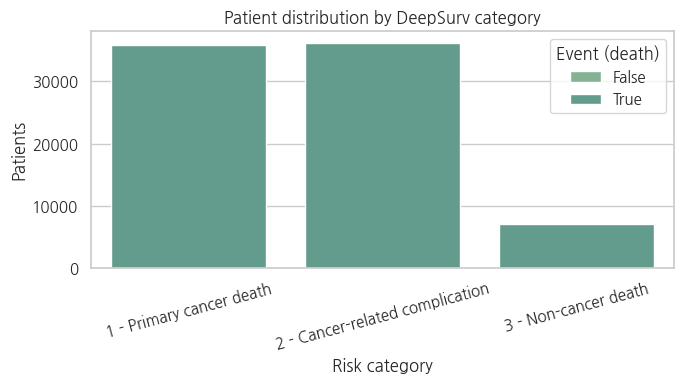

In [61]:
# 범주별 환자 분포를 시각화합니다.
plot_df = encoded_df[encoded_df['category'].isin(category_order)].copy()
plot_df['category_label'] = decode_series(plot_df, 'category_label')
plot_df['event'] = decode_series(plot_df, 'event').astype(bool)

plt.figure(figsize=(7, 4))
sns.countplot(
    data=plot_df,
    x='category_label',
    order=[category_labels[c] for c in category_order if category_labels.get(c)],
    hue='event',
    hue_order=[False, True],
)
plt.title('Patient distribution by DeepSurv category')
plt.xlabel('Risk category')
plt.ylabel('Patients')
plt.xticks(rotation=15)

handles, labels = plt.gca().get_legend_handles_labels()
label_map = {False: 'Alive/censored', True: 'Dead'}
if handles:
    plt.legend(handles, [label_map.get(label, label) for label in labels], title='Event (death)')
plt.tight_layout()


### 3-month interval event rates

각 범주별로 3개월 간격의 위험도(사건률)와 누적 사망률을 계산해 고위험 시점을 찾습니다.


In [62]:
# 3개월 간격 사건률 분석에 필요한 보조 라이브러리를 불러옵니다.
import math
import numpy as np

interval_months = 3
tail_threshold = 240  # 표본이 급격히 줄어드는 꼬리 구간을 하나로 묶는 기준선
time_col = 'Survival months'

valid = encoded_df[encoded_df['category'].isin(category_order)].dropna(subset=[time_col]).copy()
valid['event_bool'] = decode_series(valid, 'event').astype(bool)

records = []
if not valid.empty:
    max_month = valid[time_col].max()
    if math.isnan(max_month):
        max_month = interval_months
    max_month = int(math.ceil(max_month / interval_months) * interval_months)
    bins = np.arange(0, max_month + interval_months, interval_months, dtype=int)

    for cat in category_order:
        cat_label = category_labels.get(cat)
        group = valid[valid['category'] == cat]
        if group.empty:
            continue
        base = len(group)
        cumulative = 0
        for start in bins[:-1]:
            end = start + interval_months

            if start >= tail_threshold:
                tail_starts = bins[:-1][bins[:-1] >= start]
                tail_end = tail_starts[-1] + interval_months
                at_risk_start = (group[time_col] >= start).sum()
                if at_risk_start == 0:
                    break
                tail_events = 0
                tail_weight = 0
                for tail_start in tail_starts:
                    tail_interval_end = tail_start + interval_months
                    at_risk_interval = (group[time_col] >= tail_start).sum()
                    events_interval = group.loc[
                        group['event_bool']
                        & (group[time_col] >= tail_start)
                        & (group[time_col] < tail_interval_end)
                    ].shape[0]
                    tail_weight += at_risk_interval
                    tail_events += events_interval

                cumulative += tail_events
                records.append({
                    'category': cat,
                    'category_label': cat_label,
                    'interval_start': int(start),
                    'interval_end': int(tail_end),
                    'interval_mid': start + (tail_end - start) / 2,
                    'interval_label': f'{start:02d}+m',
                    'interval_marker': int(tail_end),
                    'at_risk': int(at_risk_start),
                    'at_risk_weighted': int(tail_weight),
                    'events': int(tail_events),
                    'event_rate': tail_events / tail_weight if tail_weight else 0,
                    'cumulative_event_rate': cumulative / base if base else 0,
                    'is_tail_interval': True,
                })
                break

            at_risk = (group[time_col] >= start).sum()
            if at_risk == 0:
                continue
            events = group.loc[
                group['event_bool']
                & (group[time_col] >= start)
                & (group[time_col] < end)
            ].shape[0]
            cumulative += events
            records.append({
                'category': cat,
                'category_label': cat_label,
                'interval_start': int(start),
                'interval_end': int(end),
                'interval_mid': start + interval_months / 2,
                'interval_label': f'{start:02d}-{end:02d}m',
                'interval_marker': int(end),
                'at_risk': int(at_risk),
                'at_risk_weighted': int(at_risk),
                'events': int(events),
                'event_rate': events / at_risk if at_risk else 0,
                'cumulative_event_rate': cumulative / base if base else 0,
                'is_tail_interval': False,
            })


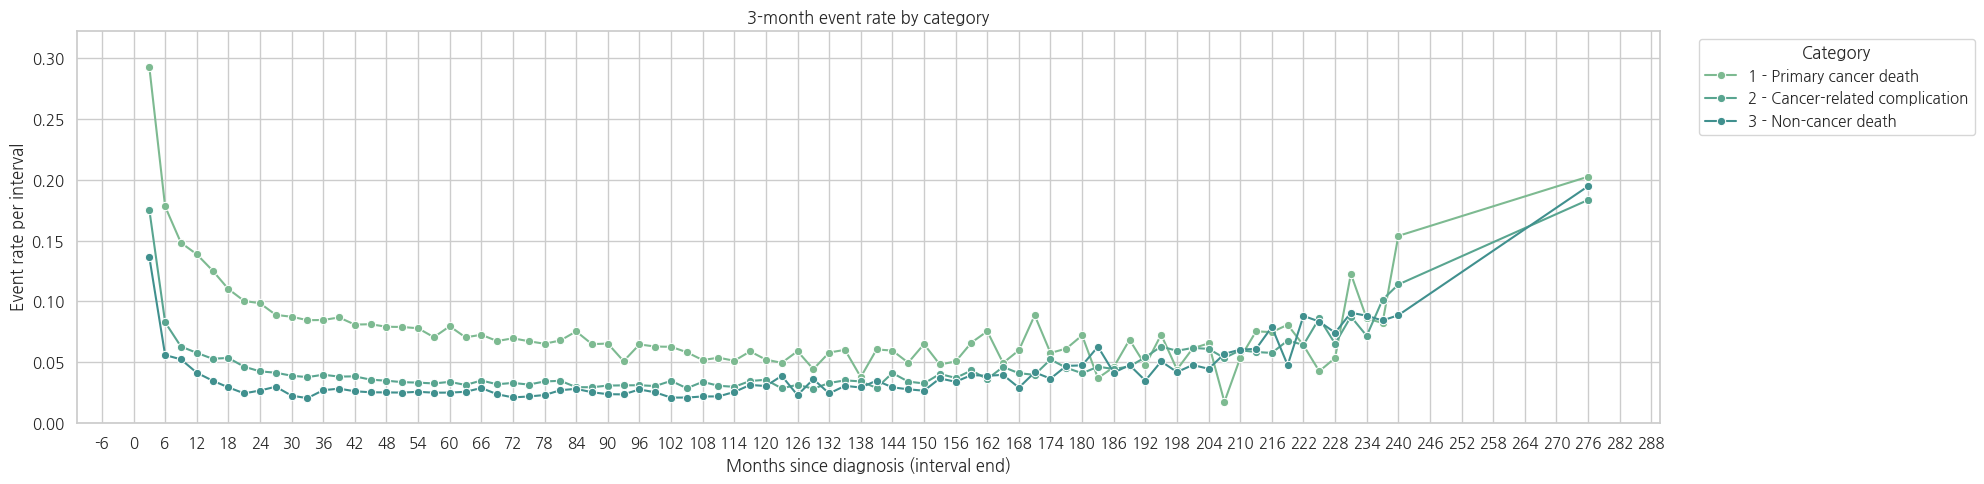

In [63]:
# 3개월 간격 사건률을 라인 차트로 비교합니다.
if records:
    line_df = interval_stats.copy()
    plt.figure(figsize=(20, 5))
    # 각 범주의 사건률 변화를 선 그래프로 겹쳐 보여줍니다.
    sns.lineplot(
        data=line_df,
        x='interval_marker',
        y='event_rate',
        hue='category_label',
        marker='o'
    )
    plt.title('3-month event rate by category')
    plt.xlabel('Months since diagnosis (interval end)')
    plt.ylabel('Event rate per interval')
    plt.gca().xaxis.set_major_locator(mstick.MultipleLocator(6))
    plt.gca().xaxis.set_minor_locator(mstick.MultipleLocator(3))
    # y축 최댓값을 데이터 범위보다 약간 크게 설정해 그래프가 답답해 보이지 않게 합니다.
    plt.ylim(0, max(0.05, line_df['event_rate'].max() * 1.1))
    plt.legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()



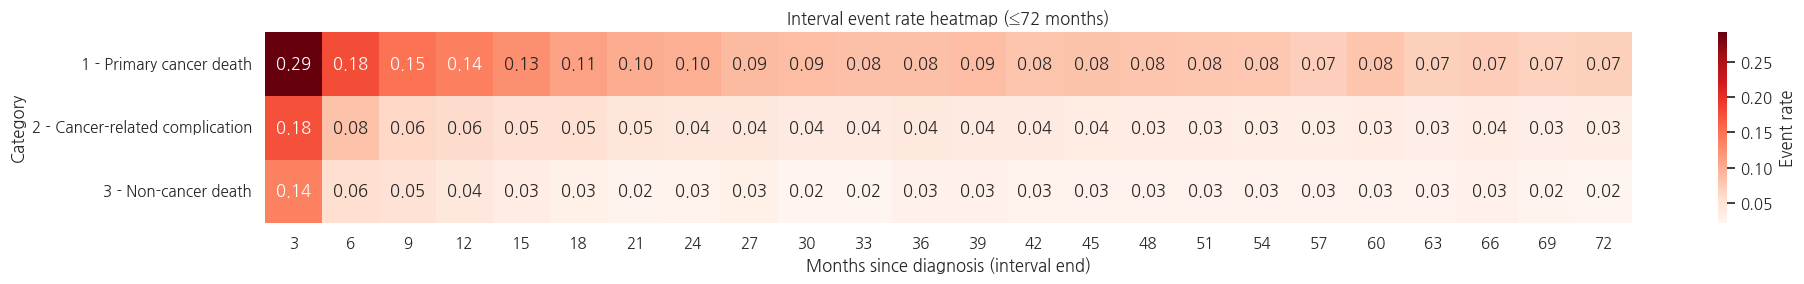

In [64]:
# 사건률 히트맵으로 고위험 시점을 가시화합니다.
if records:
    # 6년(72개월) 이내의 데이터만 선택해 실제 분석에 많이 쓰는 기간을 집중적으로 살펴봅니다.
    heatmap_scope = interval_stats[interval_stats['interval_marker'] <= 72]
    if heatmap_scope.empty:
        print('No interval data within 72 months for heatmap.')
    else:
        heatmap_df = (
            heatmap_scope.pivot_table(
                index='category_label',
                columns='interval_marker',
                values='event_rate',
                fill_value=0
            )
            .reindex([category_labels[c] for c in category_order if category_labels.get(c)], fill_value=0)
        )
        heatmap_df = heatmap_df.sort_index(axis=1)
        plt.figure(figsize=(20, 3))
        # 히트맵 색상으로 사건률의 높고 낮음을 직관적으로 표현합니다.
        sns.heatmap(
            heatmap_df,
            annot=True,
            fmt='.2f',
            cmap='Reds',
            cbar_kws={'label': 'Event rate'}
        )
        plt.title('Interval event rate heatmap (≤72 months)')
        plt.xlabel('Months since diagnosis (interval end)')
        plt.ylabel('Category')
        plt.tight_layout()



In [65]:
# 범주별 최고 위험 구간을 요약합니다.
if records:
    peak_windows = (
        interval_stats.sort_values(['category_label', 'event_rate'], ascending=[True, False])
                     # 범주별로 사건률이 가장 높은 구간을 하나씩 선택합니다.
                     .groupby('category_label', as_index=False)
                     .first()[['category_label', 'interval_label', 'event_rate', 'at_risk']]
                     .rename(columns={
                         'interval_label': 'peak_interval',
                         'event_rate': 'peak_event_rate',
                     })
    )
    peak_windows['peak_event_rate'] = peak_windows['peak_event_rate'].round(2)
    # 각 범주에서 어느 시기에 위험이 집중되는지 표로 확인합니다.
    display(peak_windows)



,category_label,peak_interval,peak_event_rate,at_risk
0,1 - Primary cancer death,00-03m,0.29,34317
1,2 - Cancer-related complication,240+m,0.18,762
2,3 - Non-cancer death,240+m,0.19,267


### Primary site mortality trend (3-month intervals)

4대 암(위, 대장, 폐, 간)을 개별 그룹으로 두고 나머지는 `Others`로 묶었습니다. 각 그룹별로 생존 개월(`Survival months`) 기준의 3개월 간격 사망률 변화를 시계열로 살펴봅니다.

,primary_site_group,interval_start,interval_end,interval_label,interval_marker,patients_at_risk,events,event_rate,cumulative_event_rate
160,Stomach,0,3,00-03m,3,45774,1456,0.031808,0.031808
161,Stomach,3,6,03-06m,6,42303,632,0.014940,0.045615
162,Stomach,6,9,06-09m,9,39922,435,0.010896,0.055119
163,Stomach,9,12,09-12m,12,37937,398,0.010491,0.063814
164,Stomach,12,15,12-15m,15,36029,320,0.008882,0.070804


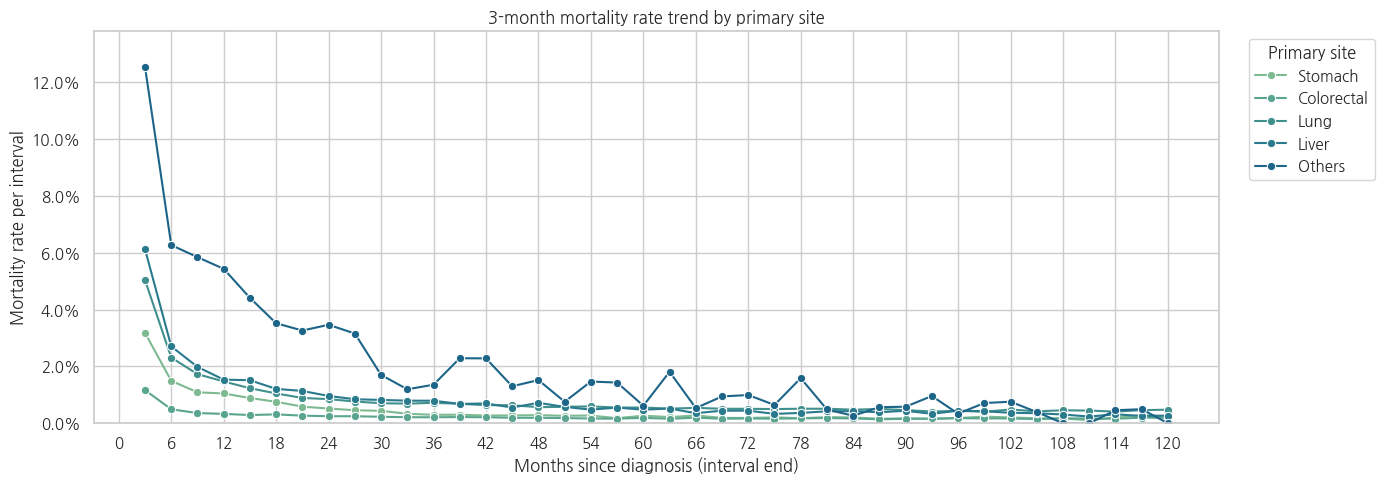

In [66]:
# 4대 암을 구분하고 나머지는 Others로 묶어 3개월 간격 사망률을 계산합니다.
import math
import numpy as np

def map_primary_site(row):
    text_parts = []
    for key in ('Primary Site - labeled', 'Primary Site'):
        value = decode_value(key, row.get(key))
        if pd.notna(value):
            text_parts.append(str(value))
    text = ' '.join(text_parts).lower()
    if any(token in text for token in ('c16', 'stomach', 'gastric')):
        return 'Stomach'
    if any(token in text for token in ('c18', 'colon', 'colorectal')):
        return 'Colorectal'
    if any(token in text for token in ('c34', 'lung')):
        return 'Lung'
    if ('c22.0' in text) or ('liver' in text):
        return 'Liver'
    return 'Others'

primary_site_groups = encoded_df.apply(map_primary_site, axis=1)

time_col = 'Survival months'
interval_months = 3
max_analysis_month = 120
site_order = ['Stomach', 'Colorectal', 'Lung', 'Liver', 'Others']

site_df = encoded_df.assign(primary_site_group=primary_site_groups)
site_df['event_bool'] = decode_series(site_df, 'event').astype(bool)

site_valid = (
    site_df
      .dropna(subset=[time_col, 'primary_site_group'])
      .assign(**{time_col: lambda d: pd.to_numeric(d[time_col], errors='coerce')})
      .dropna(subset=[time_col])
      .copy()
)

records = []
for site, group in site_valid.groupby('primary_site_group'):
    if group.empty:
        continue
    max_month = group[time_col].max()
    if pd.isna(max_month) or max_month < 0:
        continue
    capped_max = min(max_analysis_month, int(math.ceil(max_month / interval_months) * interval_months))
    bins = np.arange(0, capped_max + interval_months, interval_months, dtype=int)
    if len(bins) < 2:
        bins = np.array([0, interval_months], dtype=int)
    cumulative_events = 0
    total_patients = len(group)
    for start, end in zip(bins[:-1], bins[1:]):
        at_risk = (group[time_col] >= start).sum()
        if at_risk == 0:
            continue
        events = group.loc[
            group['event_bool']
            & (group[time_col] >= start)
            & (group[time_col] < end)
        ].shape[0]
        cumulative_events += events
        records.append({
            'primary_site_group': site,
            'interval_start': int(start),
            'interval_end': int(end),
            'interval_label': f"{int(start):02d}-{int(end):02d}m",
            'interval_marker': int(end),
            'patients_at_risk': int(at_risk),
            'events': int(events),
            'event_rate': events / at_risk if at_risk else 0.0,
            'cumulative_event_rate': cumulative_events / total_patients if total_patients else 0.0,
        })

primary_site_interval = pd.DataFrame(records)

if primary_site_interval.empty:
    print('No interval data available for primary site analysis.')
else:
    site_levels = [s for s in site_order if s in primary_site_interval['primary_site_group'].unique()]
    primary_site_interval['primary_site_group'] = pd.Categorical(primary_site_interval['primary_site_group'], categories=site_levels, ordered=True)
    primary_site_interval = primary_site_interval.sort_values(['primary_site_group', 'interval_marker'])
    plt.figure(figsize=(14, 5))
    sns.lineplot(
        data=primary_site_interval,
        x='interval_marker',
        y='event_rate',
        hue='primary_site_group',
        marker='o'
    )
    plt.title('3-month mortality rate trend by primary site')
    plt.xlabel('Months since diagnosis (interval end)')
    plt.ylabel('Mortality rate per interval')
    plt.gca().yaxis.set_major_formatter(mstick.PercentFormatter(1.0))
    plt.gca().xaxis.set_major_locator(mstick.MultipleLocator(6))
    plt.gca().xaxis.set_minor_locator(mstick.MultipleLocator(3))
    y_max = primary_site_interval['event_rate'].max()
    plt.ylim(0, max(0.02, y_max * 1.1))
    plt.legend(title='Primary site', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    display(primary_site_interval.head())


### Summary stage mortality trend (3-month intervals)

`Combined Summary Stage with Expanded Regional Codes (2004+)`를 기준으로 블랭크와 미상 값을 `Unknowns`로 묶고, 3개월 간격 사망 사건(event=1) 확률을 비교합니다.


,summary_stage_group,interval_start,interval_end,interval_label,interval_marker,patients_at_risk,events,event_rate,cumulative_event_rate
40,In situ,0,3,00-03m,3,25,0,0.0,0.0
41,In situ,3,6,03-06m,6,25,0,0.0,0.0
42,In situ,6,9,06-09m,9,25,0,0.0,0.0
43,In situ,9,12,09-12m,12,25,0,0.0,0.0
44,In situ,12,15,12-15m,15,25,0,0.0,0.0


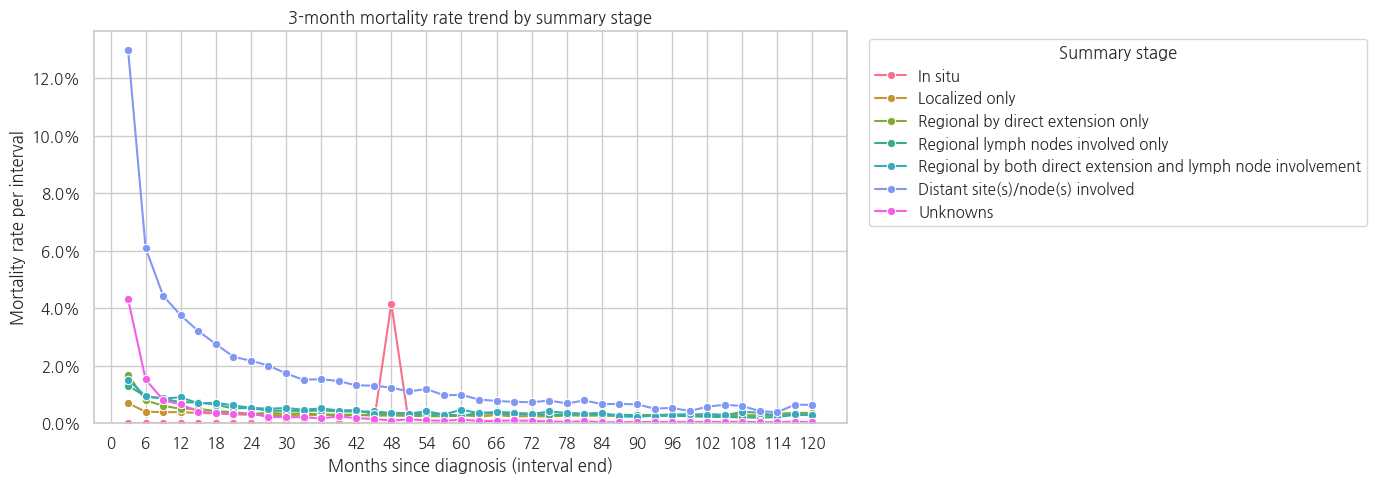

In [67]:
# 요약 병기별 3개월 간격 사망률(event=1)을 계산하고 시각화합니다.
stage_col = 'Combined Summary Stage with Expanded Regional Codes (2004+)'

def normalize_stage(value):
    if pd.isna(value):
        return 'Unknowns'
    text = str(value).strip()
    lowered = text.lower()
    if not text:
        return 'Unknowns'
    if 'unknown' in lowered or 'unstaged' in lowered or 'unspecified' in lowered or 'dco' in lowered:
        return 'Unknowns'
    if 'blank' in lowered:
        return 'Unknowns'
    return text

stage_series = decode_series(encoded_df, stage_col)
summary_stage_group = stage_series.map(normalize_stage)

stage_order = [
    'In situ',
    'Localized only',
    'Regional by direct extension only',
    'Regional lymph nodes involved only',
    'Regional by both direct extension and lymph node involvement',
    'Distant site(s)/node(s) involved',
    'Unknowns',
]

stage_df = encoded_df.assign(summary_stage_group=summary_stage_group)
stage_df['event_bool'] = decode_series(stage_df, 'event').astype(bool)

records = []
for stage_group, group in stage_df.groupby('summary_stage_group', dropna=False):
    if group.empty:
        continue
    max_month = group[time_col].max()
    if pd.isna(max_month) or max_month < 0:
        continue
    capped_max = min(max_analysis_month, int(math.ceil(max_month / interval_months) * interval_months))
    bins = np.arange(0, capped_max + interval_months, interval_months, dtype=int)
    if len(bins) < 2:
        bins = np.array([0, interval_months], dtype=int)
    cumulative_events = 0
    total_patients = len(group)
    for start, end in zip(bins[:-1], bins[1:]):
        at_risk = (group[time_col] >= start).sum()
        if at_risk == 0:
            continue
        events = group.loc[
            group['event_bool']
            & (group[time_col] >= start)
            & (group[time_col] < end)
        ].shape[0]
        cumulative_events += events
        records.append({
            'summary_stage_group': stage_group,
            'interval_start': int(start),
            'interval_end': int(end),
            'interval_label': f"{int(start):02d}-{int(end):02d}m",
            'interval_marker': int(end),
            'patients_at_risk': int(at_risk),
            'events': int(events),
            'event_rate': events / at_risk if at_risk else 0.0,
            'cumulative_event_rate': cumulative_events / total_patients if total_patients else 0.0,
        })

summary_stage_interval = pd.DataFrame(records)

if summary_stage_interval.empty:
    print('No interval data available for summary stage analysis.')
else:
    stage_levels = [s for s in stage_order if s in summary_stage_interval['summary_stage_group'].unique()]
    remaining = sorted(set(summary_stage_interval['summary_stage_group']) - set(stage_levels))
    stage_levels.extend(remaining)
    summary_stage_interval['summary_stage_group'] = pd.Categorical(summary_stage_interval['summary_stage_group'], categories=stage_levels, ordered=True)
    summary_stage_interval = summary_stage_interval.sort_values(['summary_stage_group', 'interval_marker'])

    plt.figure(figsize=(14, 5))
    sns.lineplot(
        data=summary_stage_interval,
        x='interval_marker',
        y='event_rate',
        hue='summary_stage_group',
        marker='o'
    )
    plt.title('3-month mortality rate trend by summary stage')
    plt.xlabel('Months since diagnosis (interval end)')
    plt.ylabel('Mortality rate per interval')
    plt.gca().yaxis.set_major_formatter(mstick.PercentFormatter(1.0))
    plt.gca().xaxis.set_major_locator(mstick.MultipleLocator(6))
    plt.gca().xaxis.set_minor_locator(mstick.MultipleLocator(3))
    y_max = summary_stage_interval['event_rate'].max() if not summary_stage_interval.empty else 0
    plt.ylim(0, max(0.02, y_max * 1.05))
    plt.legend(title='Summary stage', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()

    display(summary_stage_interval.head())


### Sex-based mortality trend (3-month intervals)

`Sex` 컬럼을 활용해 성별별 3개월 간격 사망 사건(event=1)의 확률 변화를 비교합니다.


,sex_group,interval_start,interval_end,interval_label,interval_marker,patients_at_risk,events,event_rate,cumulative_event_rate
0,Female,0,3,00-03m,3,267167,7424,0.027788,0.027788
1,Female,3,6,03-06m,6,249861,3103,0.012419,0.039402
2,Female,6,9,06-09m,9,238159,2193,0.009208,0.047611
3,Female,9,12,09-12m,12,227756,1840,0.008079,0.054498
4,Female,12,15,12-15m,15,218383,1428,0.006539,0.059843


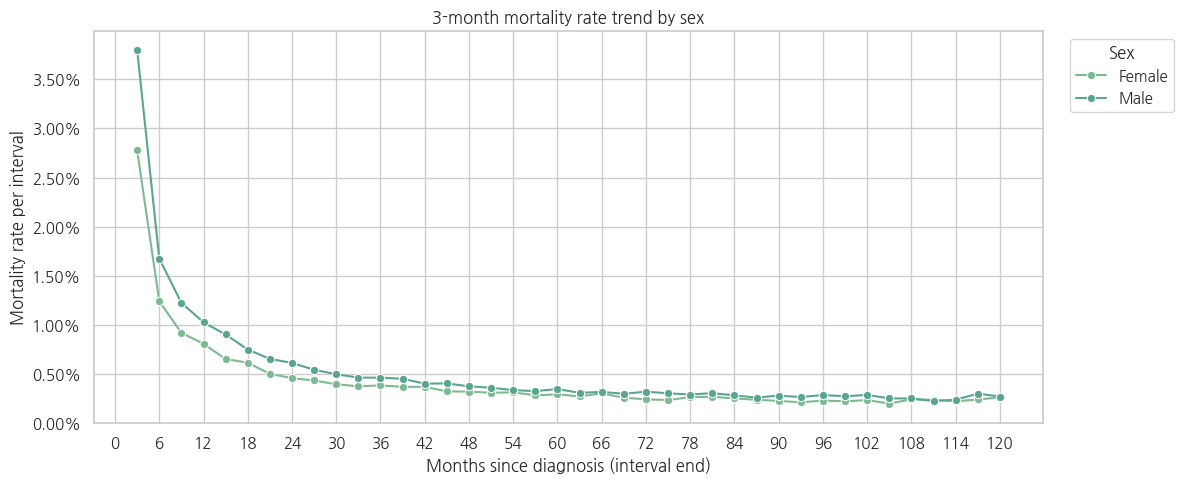

In [68]:
# 성별별 3개월 간격 사망률(event=1) 추이를 계산하고 시각화합니다.
sex_col = 'Sex'
sex_series = decode_series(encoded_df, sex_col).fillna('Unknown')

sex_order = ['Female', 'Male', 'Unknown']

sex_df = encoded_df.assign(sex_group=sex_series)
sex_df['event_bool'] = decode_series(sex_df, 'event').astype(bool)
sex_valid = (
    sex_df
      .dropna(subset=[time_col])
      .assign(**{time_col: lambda d: pd.to_numeric(d[time_col], errors='coerce')})
      .dropna(subset=[time_col])
      .copy()
)

records = []
for sex_group, group in sex_valid.groupby('sex_group'):
    if group.empty:
        continue
    max_month = group[time_col].max()
    if pd.isna(max_month) or max_month < 0:
        continue
    capped_max = min(max_analysis_month, int(math.ceil(max_month / interval_months) * interval_months))
    bins = np.arange(0, capped_max + interval_months, interval_months, dtype=int)
    if len(bins) < 2:
        bins = np.array([0, interval_months], dtype=int)
    cumulative_events = 0
    total_patients = len(group)
    for start, end in zip(bins[:-1], bins[1:]):
        at_risk = (group[time_col] >= start).sum()
        if at_risk == 0:
            continue
        events = group.loc[
            group['event_bool']
            & (group[time_col] >= start)
            & (group[time_col] < end)
        ].shape[0]
        cumulative_events += events
        records.append({
            'sex_group': sex_group,
            'interval_start': int(start),
            'interval_end': int(end),
            'interval_label': f"{int(start):02d}-{int(end):02d}m",
            'interval_marker': int(end),
            'patients_at_risk': int(at_risk),
            'events': int(events),
            'event_rate': events / at_risk if at_risk else 0.0,
            'cumulative_event_rate': cumulative_events / total_patients if total_patients else 0.0,
        })

sex_interval = pd.DataFrame(records)

if sex_interval.empty:
    print('No interval data available for sex analysis.')
else:
    unique_groups = list(sex_interval['sex_group'].unique())
    sex_levels = [s for s in sex_order if s in unique_groups]
    remaining = sorted(set(unique_groups) - set(sex_levels))
    sex_levels.extend(remaining)
    sex_interval['sex_group'] = pd.Categorical(sex_interval['sex_group'], categories=sex_levels, ordered=True)
    sex_interval = sex_interval.sort_values(['sex_group', 'interval_marker'])

    plt.figure(figsize=(12, 5))
    sns.lineplot(
        data=sex_interval,
        x='interval_marker',
        y='event_rate',
        hue='sex_group',
        marker='o'
    )
    plt.title('3-month mortality rate trend by sex')
    plt.xlabel('Months since diagnosis (interval end)')
    plt.ylabel('Mortality rate per interval')
    plt.gca().yaxis.set_major_formatter(mstick.PercentFormatter(1.0))
    plt.gca().xaxis.set_major_locator(mstick.MultipleLocator(6))
    plt.gca().xaxis.set_minor_locator(mstick.MultipleLocator(3))
    y_max = sex_interval['event_rate'].max() if not sex_interval.empty else 0
    plt.ylim(0, max(0.02, y_max * 1.05))
    plt.legend(title='Sex', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()

    display(sex_interval.head())


### Age-group mortality trend (3-month intervals)

연령 재코딩(`Age recode with <1 year olds and 90+`)을 그대로 사용해 나이대별 사망 사건(event=1) 비중을 3개월 간격으로 비교합니다.

,age_group,interval_start,interval_end,interval_label,interval_marker,patients_at_risk,events,event_rate,cumulative_event_rate
0,00 years,0,3,00-03m,3,241,3,0.012448,0.012448
1,00 years,3,6,03-06m,6,231,0,0.000000,0.012448
2,00 years,6,9,06-09m,9,228,0,0.000000,0.012448
3,00 years,9,12,09-12m,12,222,0,0.000000,0.012448
4,00 years,12,15,12-15m,15,219,0,0.000000,0.012448


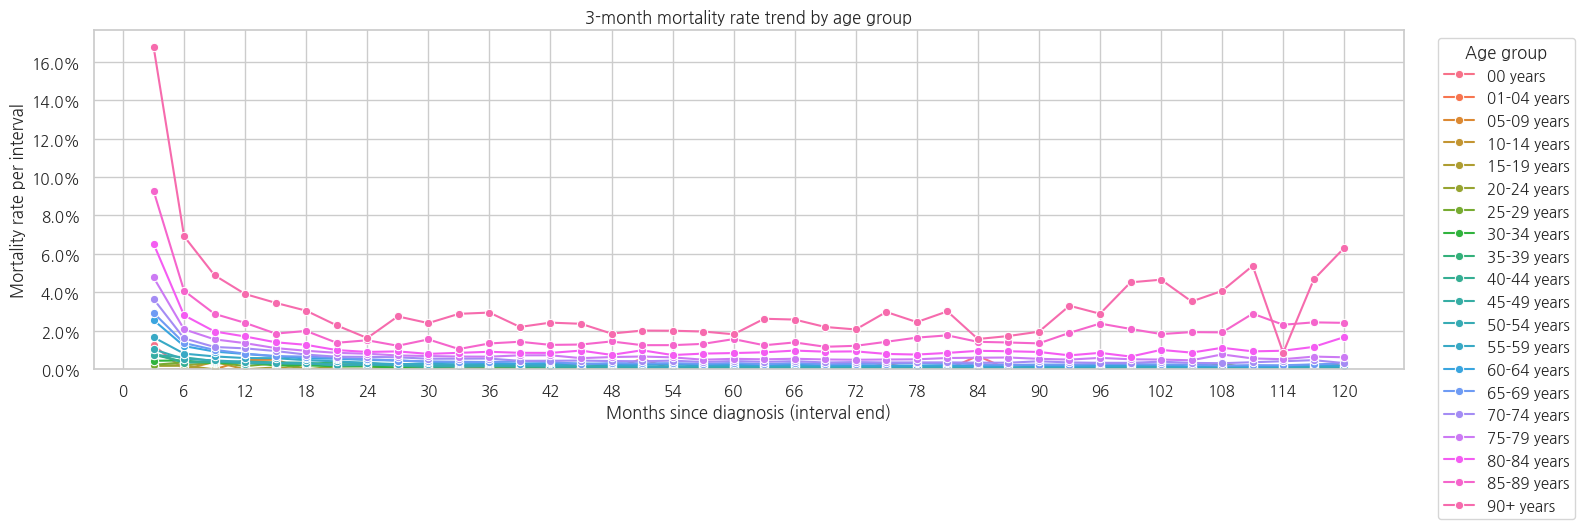

In [69]:
# 연령대별 3개월 간격 사망률(event=1)을 계산하고 시각화합니다.
age_col = 'Age recode with <1 year olds and 90+'
age_series = decode_series(encoded_df, age_col).fillna('Unknown')

age_order = [
    '00 years', '01-04 years', '05-09 years', '10-14 years', '15-19 years',
    '20-24 years', '25-29 years', '30-34 years', '35-39 years', '40-44 years',
    '45-49 years', '50-54 years', '55-59 years', '60-64 years', '65-69 years',
    '70-74 years', '75-79 years', '80-84 years', '85-89 years', '90+ years',
    'Unknown'
]

age_df = encoded_df.assign(age_group=age_series)
age_df['event_bool'] = decode_series(age_df, 'event').astype(bool)
age_valid = (
    age_df
      .dropna(subset=[time_col])
      .assign(**{time_col: lambda d: pd.to_numeric(d[time_col], errors='coerce')})
      .dropna(subset=[time_col])
      .copy()
)

records = []
for age_group, group in age_valid.groupby('age_group'):
    if group.empty:
        continue
    max_month = group[time_col].max()
    if pd.isna(max_month) or max_month < 0:
        continue
    capped_max = min(max_analysis_month, int(math.ceil(max_month / interval_months) * interval_months))
    bins = np.arange(0, capped_max + interval_months, interval_months, dtype=int)
    if len(bins) < 2:
        bins = np.array([0, interval_months], dtype=int)
    cumulative_events = 0
    total_patients = len(group)
    for start, end in zip(bins[:-1], bins[1:]):
        at_risk = (group[time_col] >= start).sum()
        if at_risk == 0:
            continue
        events = group.loc[
            group['event_bool']
            & (group[time_col] >= start)
            & (group[time_col] < end)
        ].shape[0]
        cumulative_events += events
        records.append({
            'age_group': age_group,
            'interval_start': int(start),
            'interval_end': int(end),
            'interval_label': f"{int(start):02d}-{int(end):02d}m",
            'interval_marker': int(end),
            'patients_at_risk': int(at_risk),
            'events': int(events),
            'event_rate': events / at_risk if at_risk else 0.0,
            'cumulative_event_rate': cumulative_events / total_patients if total_patients else 0.0,
        })

age_interval = pd.DataFrame(records)

if age_interval.empty:
    print('No interval data available for age analysis.')
else:
    age_levels = [a for a in age_order if a in age_interval['age_group'].unique()]
    remaining = sorted(set(age_interval['age_group']) - set(age_levels))
    age_levels.extend(remaining)
    age_interval['age_group'] = pd.Categorical(age_interval['age_group'], categories=age_levels, ordered=True)
    age_interval = age_interval.sort_values(['age_group', 'interval_marker'])

    plt.figure(figsize=(16, 5))
    sns.lineplot(
        data=age_interval,
        x='interval_marker',
        y='event_rate',
        hue='age_group',
        marker='o'
    )
    plt.title('3-month mortality rate trend by age group')
    plt.xlabel('Months since diagnosis (interval end)')
    plt.ylabel('Mortality rate per interval')
    plt.gca().yaxis.set_major_formatter(mstick.PercentFormatter(1.0))
    plt.gca().xaxis.set_major_locator(mstick.MultipleLocator(6))
    plt.gca().xaxis.set_minor_locator(mstick.MultipleLocator(3))
    y_max = age_interval['event_rate'].max() if not age_interval.empty else 0
    plt.ylim(0, max(0.02, y_max * 1.05))
    plt.legend(title='Age group', bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1)
    plt.tight_layout()

    display(age_interval.head())


### Sequence number event probability trend (3-month intervals)

각 환자의 다발성 원발암 순서를 나타내는 `Sequence number` 값별로 3개월 간격 사건 발생 확률(event=1)을 비교합니다.

,sequence,interval_start,interval_end,interval_mid,interval_label,interval_marker,at_risk,at_risk_weighted,events,event_rate,cumulative_event_rate,is_tail_interval
0,One primary only,0,3,1.5,00-03m,3,358758,358758,13457,0.037510,0.037510,False
1,One primary only,3,6,4.5,03-06m,6,330019,330019,5352,0.016217,0.052428,False
2,One primary only,6,9,7.5,06-09m,9,311924,311924,3587,0.011500,0.062426,False
3,One primary only,9,12,10.5,09-12m,12,296695,296695,2861,0.009643,0.070401,False
4,One primary only,12,15,13.5,12-15m,15,283242,283242,2256,0.007965,0.076690,False


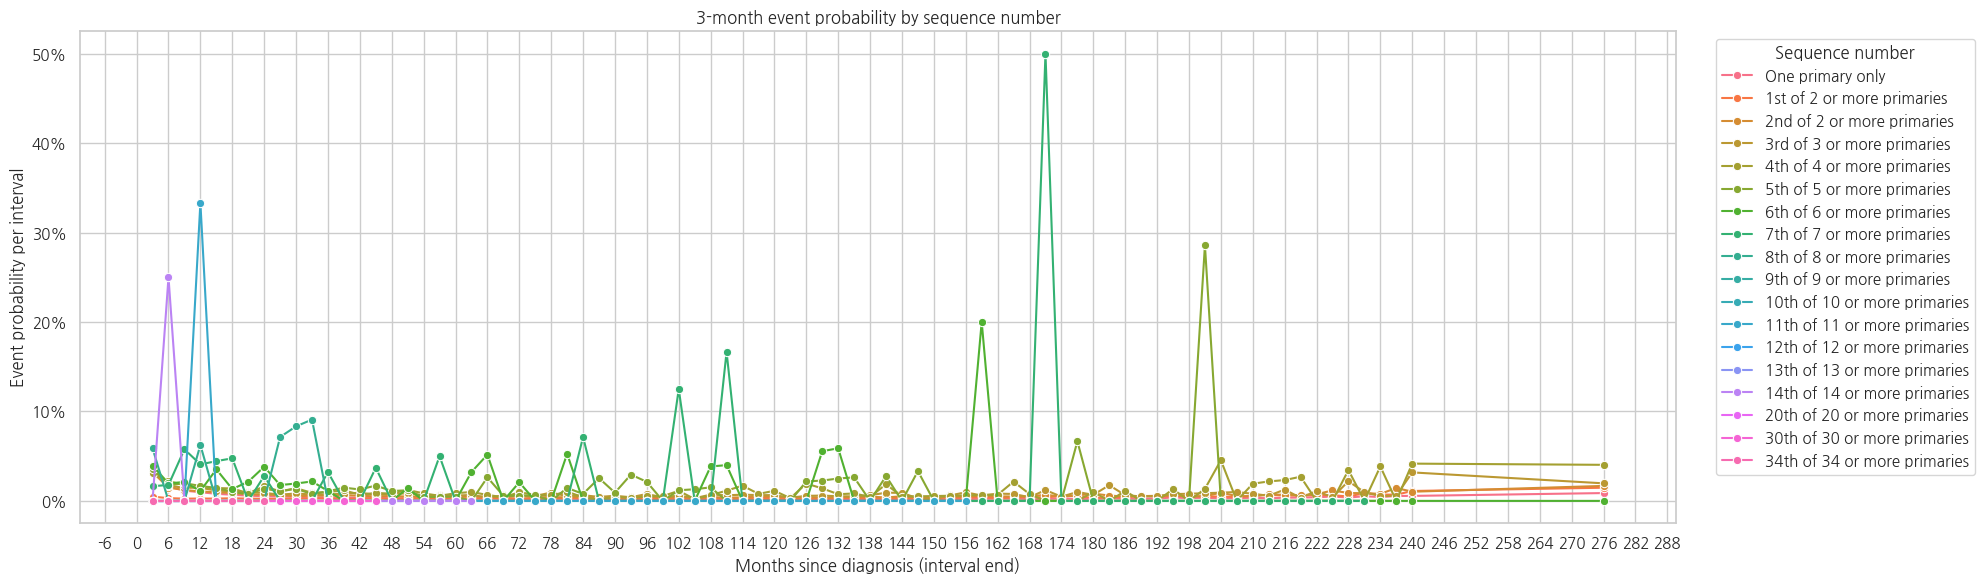

In [70]:
# Sequence number별 3개월 간격 사건 확률을 계산하고 시각화합니다.
import re

sequence_time_col = time_col
sequence_interval_months = interval_months
sequence_tail_threshold = tail_threshold
sequence_valid = (
    encoded_df
      .dropna(subset=[sequence_time_col, 'Sequence number'])
      .copy()
)
sequence_valid['Sequence number'] = decode_series(sequence_valid, 'Sequence number').astype(str).str.strip()
sequence_valid[sequence_time_col] = pd.to_numeric(sequence_valid[sequence_time_col], errors='coerce')
sequence_valid['event_bool'] = decode_series(sequence_valid, 'event').astype(bool)
sequence_valid = sequence_valid.dropna(subset=[sequence_time_col])

def sequence_sort_key(seq: str):
    if seq == 'One primary only':
        return (0, 0)
    match = re.match(r'(\d+)', seq or '')
    if match:
        return (1, int(match.group(1)))
    return (2, seq or '')

sequence_levels = sorted(sequence_valid['Sequence number'].unique(), key=sequence_sort_key)
sequence_records = []

if not sequence_valid.empty:
    max_month = sequence_valid[sequence_time_col].max()
    if math.isnan(max_month):
        max_month = sequence_interval_months
    max_month = int(math.ceil(max_month / sequence_interval_months) * sequence_interval_months)
    bins = np.arange(0, max_month + sequence_interval_months, sequence_interval_months, dtype=int)

    for seq in sequence_levels:
        group = sequence_valid[sequence_valid['Sequence number'] == seq]
        if group.empty:
            continue
        base = len(group)
        cumulative = 0
        for start in bins[:-1]:
            end = start + sequence_interval_months
            if start >= sequence_tail_threshold:
                tail_starts = bins[:-1][bins[:-1] >= start]
                tail_end = tail_starts[-1] + sequence_interval_months
                at_risk_start = int((group[sequence_time_col] >= start).sum())
                if at_risk_start == 0:
                    break
                tail_events = 0
                tail_weight = 0
                for tail_start in tail_starts:
                    tail_interval_end = tail_start + sequence_interval_months
                    at_risk_interval = int((group[sequence_time_col] >= tail_start).sum())
                    events_interval = int(group.loc[
                        group['event_bool']
                        & (group[sequence_time_col] >= tail_start)
                        & (group[sequence_time_col] < tail_interval_end)
                    ].shape[0])
                    tail_weight += at_risk_interval
                    tail_events += events_interval

                cumulative += tail_events
                sequence_records.append({
                    'sequence': seq,
                    'interval_start': int(start),
                    'interval_end': int(tail_end),
                    'interval_mid': start + (tail_end - start) / 2,
                    'interval_label': f'{start:02d}+m',
                    'interval_marker': int(tail_end),
                    'at_risk': at_risk_start,
                    'at_risk_weighted': int(tail_weight),
                    'events': int(tail_events),
                    'event_rate': tail_events / tail_weight if tail_weight else 0,
                    'cumulative_event_rate': cumulative / base if base else 0,
                    'is_tail_interval': True,
                })
                break

            at_risk = int((group[sequence_time_col] >= start).sum())
            if at_risk == 0:
                continue
            events = int(group.loc[
                group['event_bool']
                & (group[sequence_time_col] >= start)
                & (group[sequence_time_col] < end)
            ].shape[0])
            cumulative += events
            sequence_records.append({
                'sequence': seq,
                'interval_start': int(start),
                'interval_end': int(end),
                'interval_mid': start + sequence_interval_months / 2,
                'interval_label': f'{start:02d}-{end:02d}m',
                'interval_marker': int(end),
                'at_risk': at_risk,
                'at_risk_weighted': at_risk,
                'events': events,
                'event_rate': events / at_risk if at_risk else 0,
                'cumulative_event_rate': cumulative / base if base else 0,
                'is_tail_interval': False,
            })

sequence_interval_stats = pd.DataFrame(sequence_records)
if not sequence_interval_stats.empty:
    display(sequence_interval_stats.head())
    plt.figure(figsize=(20, 6))
    sns.lineplot(
        data=sequence_interval_stats,
        x='interval_marker',
        y='event_rate',
        hue='sequence',
        marker='o'
    )
    plt.title('3-month event probability by sequence number')
    plt.xlabel('Months since diagnosis (interval end)')
    plt.ylabel('Event probability per interval')
    plt.gca().xaxis.set_major_locator(mstick.MultipleLocator(6))
    plt.gca().xaxis.set_minor_locator(mstick.MultipleLocator(3))
    plt.gca().yaxis.set_major_formatter(mstick.PercentFormatter(1.0))
    plt.legend(title='Sequence number', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
else:
    print('No data available to chart sequence-level event probability.')


### 데이터 인코딩
`category_encoding`에 `encoding='onehot'`을 전달하면 더미 변수를 만들 수 있으며, `ENCODING_CATEGORIES`와 `category_decoding`을 이용해 언제든 원본 라벨을 복원할 수 있습니다.


In [71]:
# 출력이 100줄까지는 생략되지 않도록 조정
pd.set_option('display.max_rows', 100)

DataAnalysis.show_value_counts(encoded_df, boundary=100)


Patient ID
continuous
--------------------
Age recode with <1 year olds and 90+
0     88255
2     79677
1     76845
7     59940
6     59814
10    45671
9     36673
4     24381
5     17826
3     13739
12     7615
11     6887
8      4463
17     2543
13     1497
16     1066
15      539
14      509
18      241
19      222
Name: count, dtype: int64
--------------------
Sex
1    268082
0    260321
Name: count, dtype: int64
--------------------
Year of diagnosis
1     92262
7     67451
5     44168
6     41631
0     34840
15    30350
8     26561
10    23472
19    20637
14    17888
12    16358
3     14732
9     13635
17    12708
22    11665
4     10610
18     9660
13     8643
2      7634
11     6844
16     6180
21     5526
20     4948
Name: count, dtype: int64
--------------------
Year of follow-up recode
0    528403
Name: count, dtype: int64
--------------------
Race recode (W, B, AI, API)
0    409043
2     57941
1     52629
4      4556
3      4234
Name: count, dtype: int64
-------------------